# Sidekick - Mixture of Least Squares
We train a mixture of least squares, experimenting with different number of components.

In [95]:
%matplotlib inline
from __future__ import print_function
import os
import sys
sys.path.insert(0, os.path.abspath('../utils/')) # Add sibling to Python path
sys.path.insert(0, os.path.abspath('../src/')) # Add sibling to Python path
sys.stdout.flush() # Print output on the fly in Notebook
import matplotlib
matplotlib.rcParams['figure.figsize'] = (12,8)
matplotlib.rcParams['font.size'] = 16
matplotlib.rcParams['legend.fontsize'] = 16
from IPython.display import display
import numpy as np
import pickle as cp
import matplotlib.pyplot as plt
from dataset import Sidekick
from model import LeastSquaresMixture
from math import floor

DATA_DIR = "../data/sidekick"

def subsample(t0, t1, n_samples):
    t = t1 - t0
    if n_samples >= t:
        return range(t0, t1)
    samples = range(t0, t1, int(np.ceil(t / float(n_samples))))
    return samples

## Load and split data

In [2]:
sk = Sidekick()
sk.load()
projects_train, projects_test = sk.split(threshold=0.7)
total = len(projects_train) + len(projects_test)

Loading data set...
Data loaded.


### Visualize projects at different times

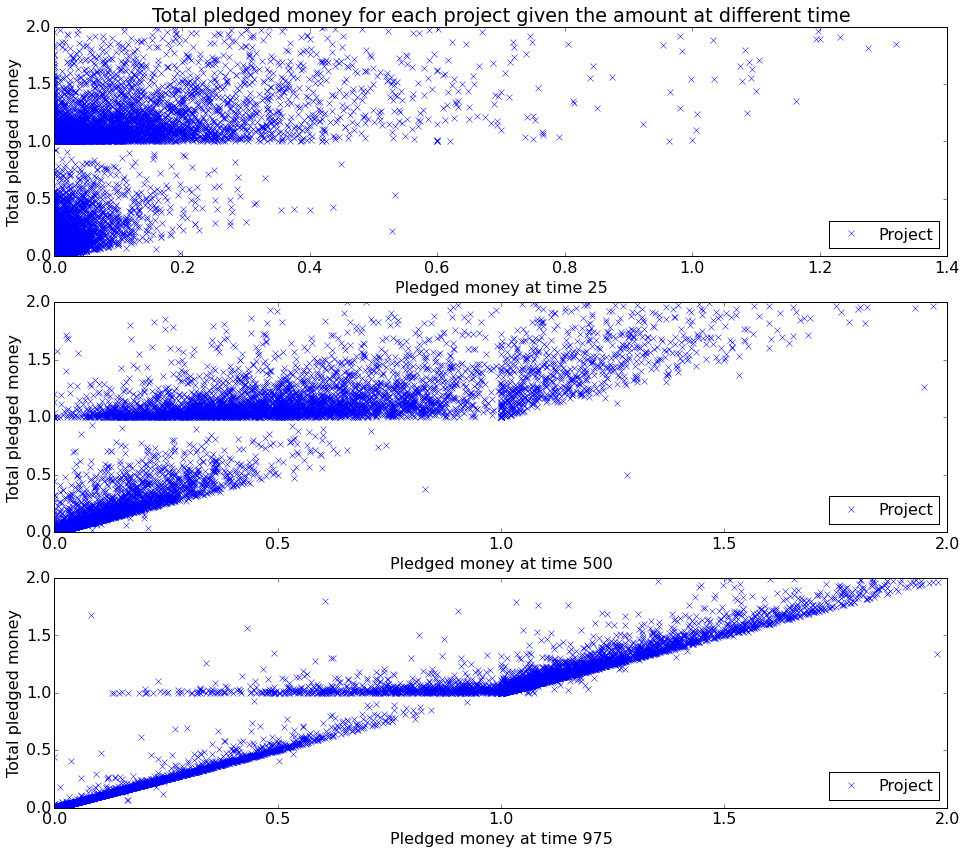

In [17]:
T = 999

plt.figure(2)
outlier_threshold = 2

plt.subplot(311)
t = 25
yt = [p.money[t] for p in projects_train if p.money[T] < outlier_threshold and p.money[t] < outlier_threshold]
yT = [p.money[T] for p in projects_train if p.money[T] < outlier_threshold and p.money[t] < outlier_threshold]
plt.plot(yt, yT, 'x')
plt.xlabel('Pledged money at time %s' % t)
plt.ylabel('Total pledged money')
plt.legend(['Project'], loc=4, numpoints=1)
plt.title('Total pledged money for each project given the amount at different time')

plt.subplot(312)
t = 500
yt = [p.money[t] for p in projects_train if p.money[T] < outlier_threshold and p.money[t] < outlier_threshold]
yT = [p.money[T] for p in projects_train if p.money[T] < outlier_threshold and p.money[t] < outlier_threshold]
plt.plot(yt, yT, 'x')
plt.xlabel('Pledged money at time %s' % t)
plt.ylabel('Total pledged money')
plt.legend(['Project'], loc=4, numpoints=1)

plt.subplot(313)
t = 975
yt = [p.money[t] for p in projects_train if p.money[T] < outlier_threshold and p.money[t] < outlier_threshold]
yT = [p.money[T] for p in projects_train if p.money[T] < outlier_threshold and p.money[t] < outlier_threshold]
plt.plot(yt, yT, 'x')
plt.xlabel('Pledged money at time %s' % t)
plt.ylabel('Total pledged money')
plt.legend(['Project'], loc=4, numpoints=1)


plt.savefig('final_money_vs_pledged_money.pdf')
plt.show()

## Data processing

In [78]:
#N = 16000
#N_train = int(floor(0.8*N))
seed = 2
t0 = 1
t1 = 500
n_samples = 1
T = 999

samples = subsample(t0, t1, n_samples)
t = len(samples)
samples = t1 - 1

#N_projects = sk.choose_n_projects(n=N, seed=seed)
#projects_train = N_projects[:N_train]
#projects_test = N_projects[N_train:]

# Remove outliers
outlier_threshold = 2  # Ignore the project whose total pledged money if more that o_t times their goal
projects_train_filtered = [p for p in projects_train if p.money[T] < outlier_threshold and p.money[samples] < outlier_threshold and p.project_id != "564047599"]
projects_test_filtered = [p for p in projects_test if p.money[T] < outlier_threshold and p.money[samples] < outlier_threshold and p.project_id != "564047599"]
#projects_test_filtered = projects_test

X_train = np.ndarray(shape=(len(projects_train_filtered), t), buffer=np.array([p.money[samples] for p in projects_train_filtered]), dtype=float) 
y_train = np.expand_dims(np.array([p.money[T] for p in projects_train_filtered]), axis=1)
X_test = np.ndarray(shape=(len(projects_test_filtered), t), buffer=np.array([p.money[samples] for p in projects_test_filtered]), dtype=float) 
y_test = np.expand_dims(np.array([p.money[T] for p in projects_test_filtered]), axis=1)

# Required to contain the prediction in a reasonable range
# The problem arises when evaluating the likelihood in the expression for gamma_nk
#X_max = np.max(X_train, axis=0)
#X_train = X_train / X_max[np.newaxis, :]
# Apply same preprocessing to testing set
#X_test = X_test / X_max[np.newaxis, :]  

total_filtered = len(X_train) + len(X_test)
print("Removed %0.2f%% outliers" % (100 - total_filtered / total * 100))
print("Training on %s projects (%0.2f%%)" % (len(X_train), len(X_train) / total_filtered * 100))
print("Testing on %s projects (%0.2f%%)" % (len(X_test), len(X_test) / total_filtered * 100))
print("Number of features: %s" % n_samples)

Removed 7.15% outliers
Training on 10341 projects (70.05%)
Testing on 4421 projects (29.95%)
Number of features: 1


## Training

### Grid Search Training

In [ ]:
K = 3
epsilon = 1e-2
iterations = 1000
random_restarts = 10
betas = np.array([1/np.var(y_train)])
lambdas = np.logspace(-8, 2, 50)
lambdas = np.array([0.0001, 0.001, 0.01, 0.1, 1, 10])
k_fold = 2

mls = LeastSquaresMixture(X_train, y_train, K=K,
                          iterations=iterations, epsilon=epsilon, random_restarts=random_restarts)
rmse_avg, rmse_std, accuracy_avg, accuracy_std = mls.grid_search(betas, lambdas, k_fold=k_fold)

print(mls)

### Simple Training

In [74]:
K = 2
beta = 1 / np.var(y_train)
epsilon = 1e0
lam = 0
iterations = 1000
random_restarts = None

mls1 = LeastSquaresMixture(X_train, y_train, 
                          K=K, beta=beta, lam=lam, 
                          iterations=iterations, epsilon=epsilon, random_restarts=random_restarts)
mls1.train(verbose=True)

print(mls1)

* Starting EM algorithm for mixture of K=2 least squares models
* Beta = 3.07836676022
* Lambda = 0
* Running at most 1000 iterations
* Stopping when complete likelihood improves less than 1.0
Obj	pi1	pi2	w11	w12	w21	w22	beta1	beta2
577.81		0.52	0.48	0.67	1.87	0.20	3.25	2.03	1.91
973.98		0.51	0.49	0.52	2.11	0.30	3.32	2.24	2.12
1452.19		0.52	0.48	0.48	2.15	0.34	3.41	2.33	2.17
1570.22		0.52	0.48	0.45	2.16	0.35	3.50	2.36	2.17
1593.81		0.52	0.48	0.44	2.16	0.36	3.57	2.38	2.16
1603.41		0.53	0.47	0.44	2.17	0.36	3.61	2.41	2.14
1607.66		0.54	0.46	0.43	2.18	0.37	3.63	2.44	2.11
1609.14		0.54	0.46	0.43	2.19	0.37	3.64	2.48	2.08
1609.23		0.55	0.45	0.43	2.20	0.37	3.64	2.52	2.03
Model:        LeastSquaresMixture (2 components)
Likelihood:   1609.227092837668
Beta:         [ 2.52265437  2.02793751]
Lambda:       0
Pi:           [ 0.55435742  0.44564258]
Weights norm: [2.246228970186547, 3.6623062556245372]
[[ 0.42863354  0.3709476 ]
 [ 2.20495303  3.64347156]]


In [87]:
K = 2
beta = 1 / np.var(y_train)
#beta = 0.0001
epsilon = 1e0
lam = 0
iterations = 1000
random_restarts = None

mls2 = LeastSquaresMixture(X_train, y_train, 
                          K=K, beta=beta, lam=lam, 
                          iterations=iterations, epsilon=epsilon, random_restarts=random_restarts)
mls2.train(verbose=True)

print(mls2)

* Starting EM algorithm for mixture of K=2 least squares models
* Beta = 3.07836676022
* Lambda = 0
* Running at most 1000 iterations
* Stopping when complete likelihood improves less than 1.0
Obj	pi1	pi2	w11	w12	w21	w22	beta1	beta2
2271.83		0.50	0.50	0.09	1.40	0.29	1.21	2.68	2.66
3728.31		0.50	0.50	0.15	1.36	0.20	1.32	5.22	5.14
6007.05		0.50	0.50	0.16	1.34	0.18	1.33	5.42	5.32
6102.22		0.51	0.49	0.17	1.34	0.18	1.33	5.43	5.31
6103.58		0.51	0.49	0.17	1.34	0.18	1.33	5.45	5.29
6103.86		0.51	0.49	0.17	1.34	0.18	1.33	5.47	5.27
Model:        LeastSquaresMixture (2 components)
Likelihood:   6103.8589374517405
Beta:         [ 5.46539733  5.27066484]
Lambda:       0
Pi:           [ 0.50906908  0.49093092]
Weights norm: [1.3504920159330509, 1.345317123278758]
[[ 0.17001608  0.17693489]
 [ 1.33974745  1.33363121]]


In [51]:
K = 2
beta = 1 / np.var(y_train)
#beta = 0.0001
epsilon = 1e0
lam = 0
iterations = 1000
random_restarts = None

mls3 = LeastSquaresMixture(X_train, y_train, 
                          K=K, beta=beta, lam=lam, 
                          iterations=iterations, epsilon=epsilon, random_restarts=random_restarts)
mls3.train(verbose=True)

print(mls3)

* Starting EM algorithm for mixture of K=2 least squares models
* Beta = 3.07795875475
* Lambda = 0
* Running at most 1000 iterations
* Stopping when complete likelihood improves less than 1.0
Obj	pi1	pi2	w11	w12	w21	w22	beta1	beta2
1515.37		0.31	0.69	0.04	1.04	0.01	1.04	1.02	2.29
3351.75		0.23	0.77	0.02	1.04	0.02	1.04	21.20	71.20
18735.76		0.17	0.83	0.10	1.03	0.00	1.04	16.27	77.41
19427.18		0.12	0.88	0.15	1.03	0.00	1.04	13.47	97.87
20476.08		0.08	0.92	0.24	1.00	0.00	1.04	10.87	118.10
21261.00		0.06	0.94	0.35	0.94	0.00	1.04	10.15	147.95
22105.79		0.06	0.94	0.46	0.84	0.00	1.04	11.45	189.49
22993.06		0.06	0.94	0.55	0.74	0.00	1.04	14.51	237.95
23798.97		0.06	0.94	0.61	0.67	0.00	1.04	18.72	285.20
24435.13		0.07	0.93	0.64	0.63	0.00	1.03	22.65	317.26
24807.35		0.07	0.93	0.64	0.62	0.00	1.03	24.97	328.63
24933.93		0.07	0.93	0.64	0.62	0.00	1.03	25.94	330.75
24959.65		0.07	0.93	0.64	0.62	0.00	1.03	26.27	330.85
24962.37		0.07	0.93	0.64	0.62	0.00	1.03	26.37	330.74
24961.87		0.07	0.93	0.64	0.62	0.0

### Display weights

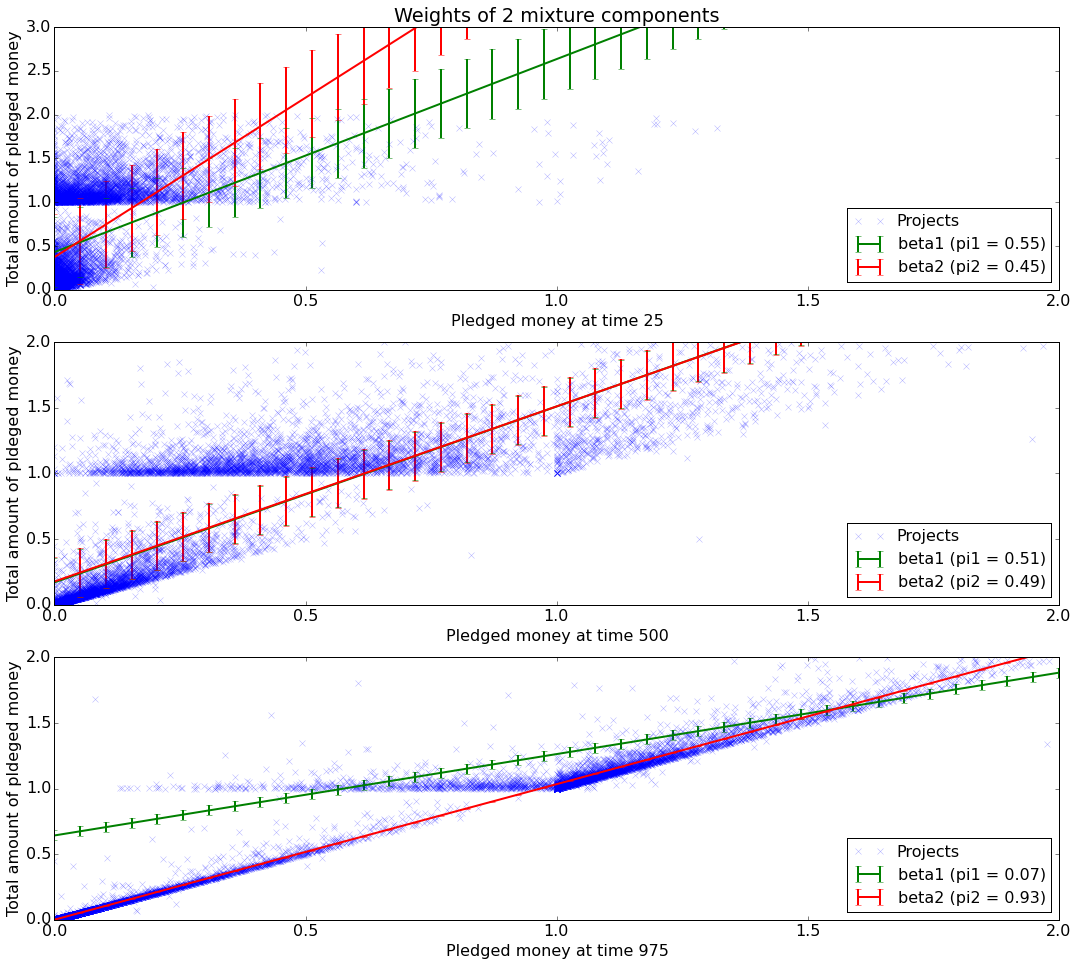

In [88]:
projects = True
n_points = 40

x1 = np.ones((n_points, 2))
x1[:, 1] = np.linspace(0, outlier_threshold, n_points)
w11 = mls1.w[:, 0]
w12 = mls1.w[:, 1]
y11 = x1.dot(w11)
y12 = x1.dot(w12)

x2 = np.ones((n_points, 2))
x2[:, 1] = np.linspace(0, outlier_threshold, n_points)
w21 = mls2.w[:, 0]
w22 = mls2.w[:, 1]
y21 = x2.dot(w21)
y22 = x2.dot(w22)

x3 = np.ones((n_points, 2))
x3[:, 1] = np.linspace(0, outlier_threshold, n_points)
w31 = mls3.w[:, 0]
w32 = mls3.w[:, 1]
y31 = x3.dot(w31)
y32 = x3.dot(w32)

plt.figure(1)

plt.subplot(311)
t = 25
if projects:
    yt = [p.money[t] for p in projects_train if p.money[T] < outlier_threshold and p.money[t] < outlier_threshold]
    yT = [p.money[T] for p in projects_train if p.money[T] < outlier_threshold and p.money[t] < outlier_threshold]
    plt.plot(yt, yT, 'x', label="Projects", alpha=0.3)
plt.errorbar(x1[:, 1], y11, x1[:, 0] / mls1.beta[0], label="beta1 (pi1 = %0.2f)" % (mls1.pi[0],), lw=2)
plt.errorbar(x1[:, 1], y12, x1[:, 0] / mls1.beta[1], label="beta2 (pi2 = %0.2f)" % (mls1.pi[1],), lw=2)
plt.title("Weights of 2 mixture components")
plt.xlabel("Pledged money at time %s" % t)
plt.ylabel("Total amount of pldeged money")
plt.xlim([0, 2])
plt.ylim([0, 3])
plt.legend(loc=4)

plt.subplot(312)
t = 500
if projects:
    yt = [p.money[t] for p in projects_train if p.money[T] < outlier_threshold and p.money[t] < outlier_threshold]
    yT = [p.money[T] for p in projects_train if p.money[T] < outlier_threshold and p.money[t] < outlier_threshold]
    plt.plot(yt, yT, 'x', label="Projects", alpha=0.3)
plt.errorbar(x2[:, 1], y21, x2[:, 0] / mls2.beta[0], label="beta1 (pi1 = %0.2f)" % (mls2.pi[0],), lw=2)
plt.errorbar(x2[:, 1], y22, x2[:, 0] / mls2.beta[1], label="beta2 (pi2 = %0.2f)" % (mls2.pi[1],), lw=2)
plt.xlabel("Pledged money at time %s" % t)
plt.ylabel("Total amount of pldeged money")
plt.xlim([0, 2])
plt.ylim([0, 2])
plt.legend(loc=4)

plt.subplot(313)
t = 975
if projects:
    yt = [p.money[t] for p in projects_train if p.money[T] < outlier_threshold and p.money[t] < outlier_threshold]
    yT = [p.money[T] for p in projects_train if p.money[T] < outlier_threshold and p.money[t] < outlier_threshold]
    plt.plot(yt, yT, 'x', label="Projects", alpha=0.3)
plt.errorbar(x3[:, 1], y31, x3[:, 0] / mls3.beta[0], label="beta1 (pi1 = %0.2f)" % (mls3.pi[0],), lw=2)
plt.errorbar(x3[:, 1], y32, x3[:, 0] / mls3.beta[1], label="beta2 (pi2 = %0.2f)" % (mls3.pi[1],), lw=2)
plt.xlabel("Pledged money at time %s" % t)
plt.ylabel("Total amount of pldeged money")
#plt.xlim([0, 3])
plt.ylim([0, 2])
plt.legend(loc=4)

plt.savefig("weights.pdf")
plt.show()

## Testing

### Full Test Set

In [16]:
rmse_failed, rmse_success, rmse, accuracy = mls1.evaluate(X_test, y_test, verbose=True)

Evaluating model LeastSquaresMixture (2 components)...
Data point (4718/4718): [####################] 100% Elapsed time: 0:00:04
Accuracy     : 0.8800339126748622
RMSE         : 2.57533653227
RMSE failed  : 0.754109210563
RMSE success : 3.67768915241


### Single Point

In [15]:
test = 12
x_new = X_test[test]
y_new = mls3.predict(x_new, posteriors=True)
y_true = y_test[test]
print("Predicted:  %s" % y_new)
#print("Posteriors: %s" % ["%0.2f%%" % (p * 100) for p in y_posteriors])
print("Actual:     %s" % y_true)

Predicted:  0.844715677913
Actual:     [ 1.02310255]


### Predictive Distribution

Predicted: 3.28447647251
Actual: 1.83020436927
pi_k: [ 0.55435742  0.44564258]


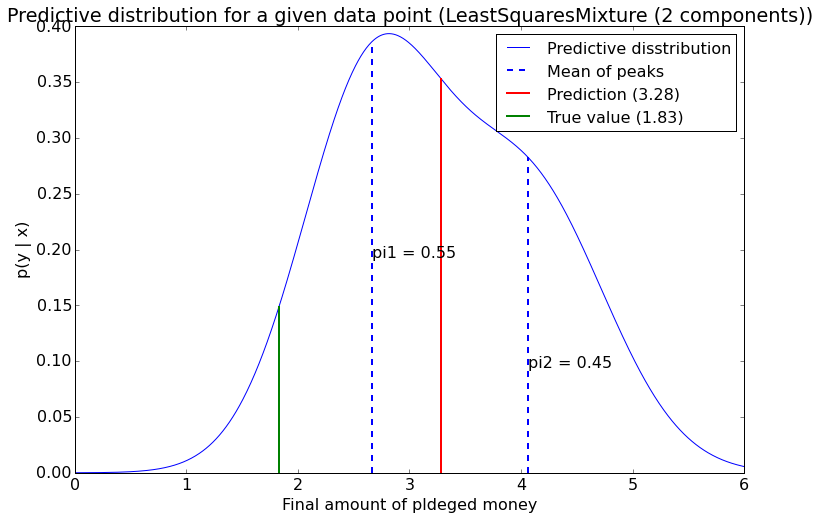

In [96]:
def predictive_distribution(mls, x, y):
    p = 0
    for k in range(mls.K):
        pi_k = mls.pi[k]
        beta_k = mls.beta[k]
        w_k = mls.w[:, k]
        p += pi_k * np.sqrt(beta_k / (2 * np.pi)) * np.exp(- beta_k / 2 * (y - np.dot(tx, w_k))**2)
    return p

mls = mls1

test = 7
outlier_threshold = 6
x_new = X_test[test]
y_new = mls.predict(x_new, posteriors=True)
y_true = y_test[test]

tx = np.ones((1, len(x_new ) + 1))
tx[0, 1:] = x_new
y = np.linspace(0, outlier_threshold, 1000)
py = predictive_distribution(mls, tx, y)

print("Predicted:", y_new)
print("Actual:", y_true[0])
print("pi_k:", mls.pi)

m1 = np.dot(tx, mls.w[:, 0])[0]
beta1 = mls.beta[0]
pi1 = mls.pi[0]
m2 = np.dot(tx, mls.w[:, 1])[0]
beta2 = mls.beta[1]
pi2 = mls.pi[1]

plt.figure()
plt.plot(y, py, label="Predictive disstribution")
plt.plot((m1, m1), (0, predictive_distribution(mls, tx, m1)), 'b--', lw=2)
plt.plot((m2, m2), (0, predictive_distribution(mls, tx, m2)), 'b--', lw=2, label="Mean of peaks")
plt.plot((y_new, y_new), (0, predictive_distribution(mls, tx, y_new)), 'r', lw=2, label="Prediction (%0.2f)" % y_new)
plt.plot((y_true, y_true), (0, predictive_distribution(mls, tx, y_true)), 'g', lw=2, label="True value (%0.2f)" % y_true)
plt.text(m1, predictive_distribution(mls, tx, m1) / 2, "pi1 = %0.2f" % mls.pi[0])
plt.text(m2, predictive_distribution(mls, tx, m2) / 3, "pi2 = %0.2f" % mls.pi[1])
plt.xticks(np.arange(min(y), max(y)+1, 1.0))
plt.title("Predictive distribution for a given data point (%s)" % mls.name)
plt.xlabel("Final amount of pldeged money")
plt.ylabel("p(y | x)")
plt.legend(loc=1)
plt.savefig("predictive_distribution.pdf")
plt.show()

## Plots

### 0-1 Loss

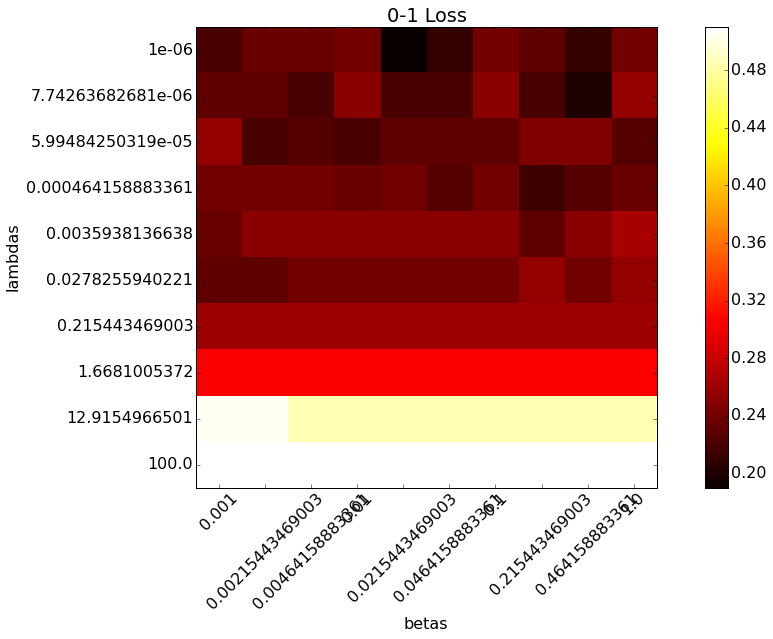

In [19]:
with open("accuracy_all_gridsearch.pkl", 'rb') as f:
    accuracy_avg = cp.load(f)
betas = np.logspace(-3, 0, 10)
lambdas = np.logspace(-6, 2, 10)

plt.subplots_adjust(left=.2, right=0.95, bottom=0.15, top=0.95)
plt.imshow(1 - np.array(accuracy_avg), interpolation='nearest', cmap=plt.cm.hot)
plt.xlabel('betas')
plt.ylabel('lambdas')
plt.colorbar()
plt.xticks(np.arange(len(betas)), ["%s" % b for b in betas], rotation=45)
plt.yticks(np.arange(len(lambdas)), ["%s" % l for l in lambdas])
plt.title('0-1 Loss')
plt.show()

In [21]:
with open("accuracy_all.pkl", 'rb') as f:
    accuracy_avg = cp.load(f)
    
lambdas = np.logspace(-6, 2, 10)
plt.errorbar(list(lambdas), [1-a[0] for a in accuracy_avg], yerr=[a[0] for a in accuracy_std])
plt.xscale('log')
plt.title("0-1 Loss (beta = %s)" % betas[0])
plt.xlabel("lambdas")
plt.ylabel("0-1 Loss")
plt.show()

NameError: name 'accuracy_std' is not defined

### RMSE

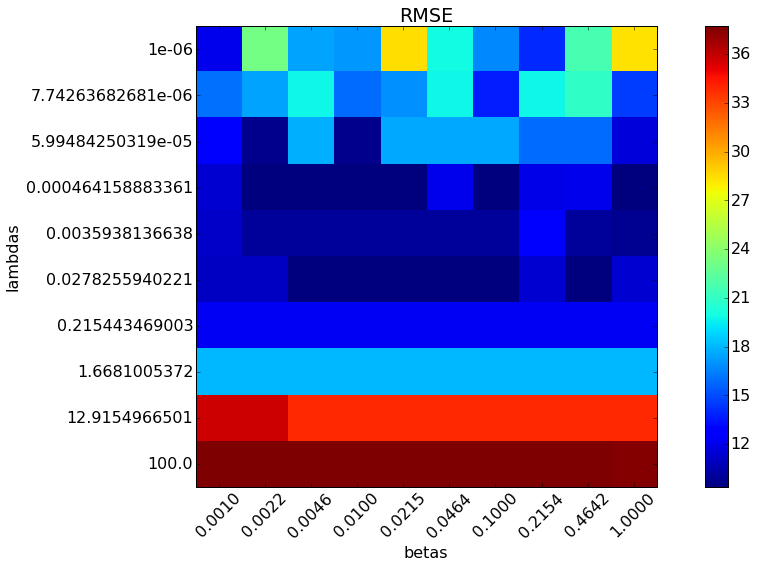

In [26]:
with open("rmse_all_gridsearch.pkl", 'rb') as f:
    rmse_avg = cp.load(f)
betas = np.logspace(-3, 0, 10)
lambdas = np.logspace(-6, 2, 10)

plt.subplots_adjust(left=.2, right=0.95, bottom=0.15, top=0.95)
plt.imshow(rmse_avg, interpolation='nearest')
plt.xticks(np.arange(len(betas)), ["%0.4f" % b for b in betas], rotation=45)
plt.yticks(np.arange(len(lambdas)), ["%s" % l for l in lambdas])
plt.colorbar()
plt.title('RMSE')
plt.xlabel('betas')
plt.ylabel('lambdas')
plt.show()

In [ ]:
plt.errorbar(list(lambdas), [r[0] for r in rmse_avg], yerr=[r[0] for r in rmse_std])
plt.xscale('log')
plt.title("RMSE (beta = %s)" % betas[0])
plt.xlabel("lambdas")
plt.ylabel("RMSE")
plt.show()